In [1]:
import os
import re
import math
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import sleep, time
from sklearn import preprocessing, svm
from sklearn.linear_model import Ridge, RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier, PassiveAggressiveRegressor, LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

In [2]:
def add_squared_col(X):
    return np.hstack((X, X**2))
marker = ['^','<','>','*','D','P']

In [3]:
col_types = {'Age': np.int32, 'Potential': np.int32, 'Overall': np.int32}
ff18 = pd.read_csv('data/Dataset.csv', usecols=['Name', 'Nationality', 'Club', 'Photo', 'Value', 'Age', 'Wage', 'Potential', 'Overall', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling'], dtype=col_types)


In [4]:
def finishing(s):
    try:
        n = int(s)
        return (1 <= n and n <= 99)
    except:
        return False

In [5]:
cols_int = ['Age', 'Potential', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']
for col in cols_int:
    ff18 = ff18.loc[ff18[col].apply(lambda x: finishing(x))]
    ff18[col] = ff18[col].astype('int')

In [6]:
ff18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13301 entries, 0 to 13499
Data columns (total 15 columns):
Name           13301 non-null object
Age            13301 non-null int64
Photo          13301 non-null object
Nationality    13301 non-null object
Overall        13301 non-null int32
Potential      13301 non-null int64
Club           13020 non-null object
Value          13301 non-null object
Wage           13301 non-null object
Aggression     13301 non-null int64
Crossing       13301 non-null int64
Dribbling      13301 non-null int64
Finishing      13301 non-null int64
Penalties      13301 non-null int64
Stamina        13301 non-null int64
dtypes: int32(1), int64(8), object(6)
memory usage: 1.6+ MB


In [7]:
def str2number(amount):
    if amount[-1] == 'M':
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)*1000000
    elif amount[-1] == 'K':
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)*1000
    else:
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)
ff18['ValueNum'] = ff18['Value'].apply(lambda x: str2number(x))

In [8]:
ff18.head(1).T

,0
Name,T. Pukki
Age,28
Photo,https://cdn.sofifa.org/players/4/19/190362.png
Nationality,Finland
Overall,76
Potential,76
Club,Norwich City
Value,€8M
Wage,€32K
Aggression,56


In [9]:
ff18.describe()

,Age,Overall,Potential,Aggression,Crossing,Dribbling,Finishing,Penalties,Stamina,ValueNum
count,13301.000000,13301.000000,13301.000000,13301.000000,13301.000000,13301.000000,13301.000000,13301.000000,13301.000000,1.330100e+04
mean,24.200135,66.494549,72.184272,62.546500,60.840012,69.728667,57.912337,56.795654,71.162920,2.612682e+06
std,4.686850,7.330823,6.089109,16.846589,17.869724,16.747357,20.105900,15.827763,13.121422,5.699004e+06
min,15.000000,41.000000,46.000000,13.000000,10.000000,8.000000,5.000000,11.000000,14.000000,0.000000e+00
25%,20.000000,62.000000,68.000000,52.000000,52.000000,66.000000,45.000000,46.000000,66.000000,3.250000e+05
50%,24.000000,67.000000,72.000000,66.000000,65.000000,74.000000,63.000000,59.000000,73.000000,7.500000e+05
75%,27.000000,71.000000,76.000000,75.000000,74.000000,79.000000,73.000000,68.000000,79.000000,2.400000e+06
max,47.000000,94.000000,95.000000,95.000000,91.000000,96.000000,94.000000,92.000000,97.000000,1.080000e+08


In [10]:
ff18.Overall.describe()

count    13301.000000
mean        66.494549
std          7.330823
min         41.000000
25%         62.000000
50%         67.000000
75%         71.000000
max         94.000000
Name: Overall, dtype: float64

In [11]:
ff18 = ff18.loc[ff18.ValueNum > 0]

In [12]:
ff18.head(5)

,Name,Age,Photo,Nationality,Overall,Potential,Club,Value,Wage,Aggression,Crossing,Dribbling,Finishing,Penalties,Stamina,ValueNum
0,T. Pukki,28,https://cdn.sofifa.org/players/4/19/190362.png,Finland,76,76,Norwich City,€8M,€32K,56,45,72,80,66,79,8000000.0
1,D. Upamecano,19,https://cdn.sofifa.org/players/4/19/229558.png,France,77,88,RB Leipzig,€13M,€18K,81,47,59,39,39,61,13000000.0
2,M. Mount,19,https://cdn.sofifa.org/players/4/19/233064.png,England,74,86,Derby County,€10M,€34K,38,69,75,67,60,74,10000000.0
3,Wesley,21,https://cdn.sofifa.org/players/4/19/232381.png,Brazil,78,85,Club Brugge KV,€15M,€21K,80,68,74,73,60,81,15000000.0
4,T. Abraham,20,https://cdn.sofifa.org/players/4/19/231352.png,England,75,85,Aston Villa,€11M,€64K,41,47,68,78,72,66,11000000.0


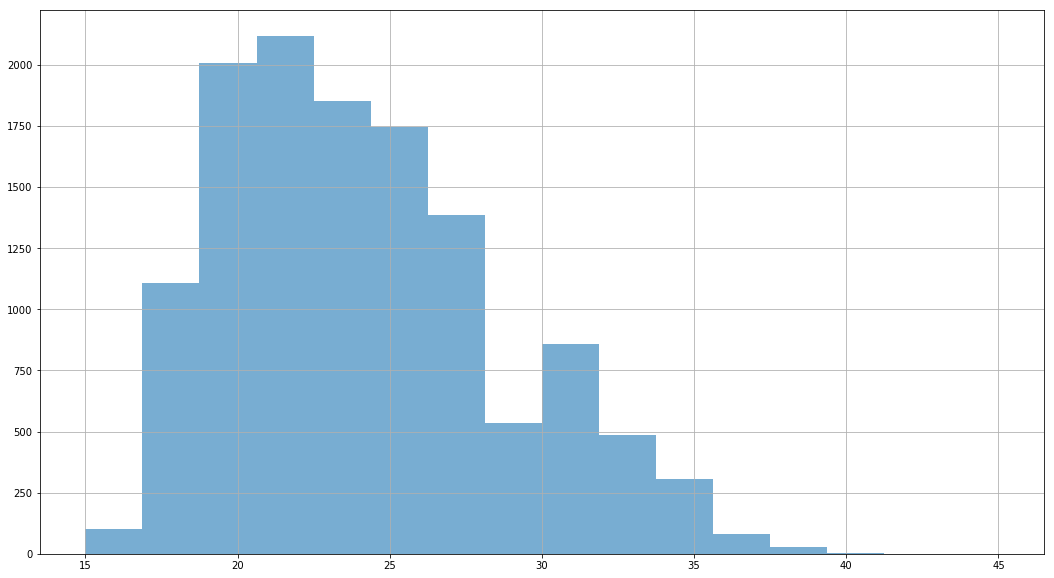

In [13]:
plt.figure(figsize=(18, 10))
plt.grid(True)
ff18.Age.hist(bins=16, alpha=.6)
plt.show()

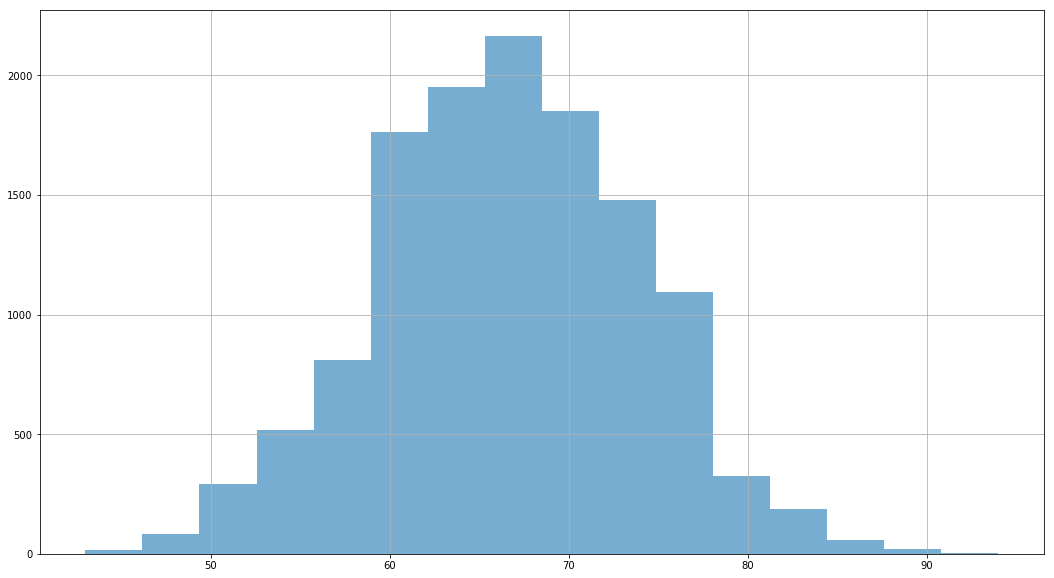

In [14]:
plt.figure(figsize=(18, 10))
ff18.Overall.hist(bins=16, alpha=.6)
plt.grid(True)
plt.show()

In [15]:
# building our predictive model
train, test = train_test_split(ff18, test_size=0.4, random_state=45)

xtrain = train[['ValueNum', 'Age', 'Finishing', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']]
ytrain = train[['Overall']]
xtest = test[['ValueNum', 'Age', 'Finishing', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']]
ytest = test[['Overall']]

In [16]:
print("Players less than 30 Million Euro {:.2f}%".format(test.loc[test.ValueNum <= 30000000].ValueNum.count().astype('float') / test.ValueNum.count().astype('float') * 100))

Players less than 30 Million Euro 99.17%


In [17]:
def pickeling(name, engine):
    pickle.HIGHEST_PROTOCOL
    f = "./pkl/{}.pickle".format(name).lower()
    if os.path.isfile(f):
        with open(f, "rb") as fh:
            u = pickle._Unpickler(fh)
            u.encoding = 'latin1'
            p = u.load()
        print("returning pickle load {} {}".format(name, time()))
        return p
    else:
        print("building clf {} {}".format(name, time()))
        clf = make_pipeline(StandardScaler(), FunctionTransformer(add_squared_col), engine)
        with open(f, "wb") as d:
            pickle.dump(clf, d)
            d.flush()
            d.close()
        sleep(5)
    pickeling(name, engine)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator SVR from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/s

returning pickle load RBF 1566693173.1407132


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


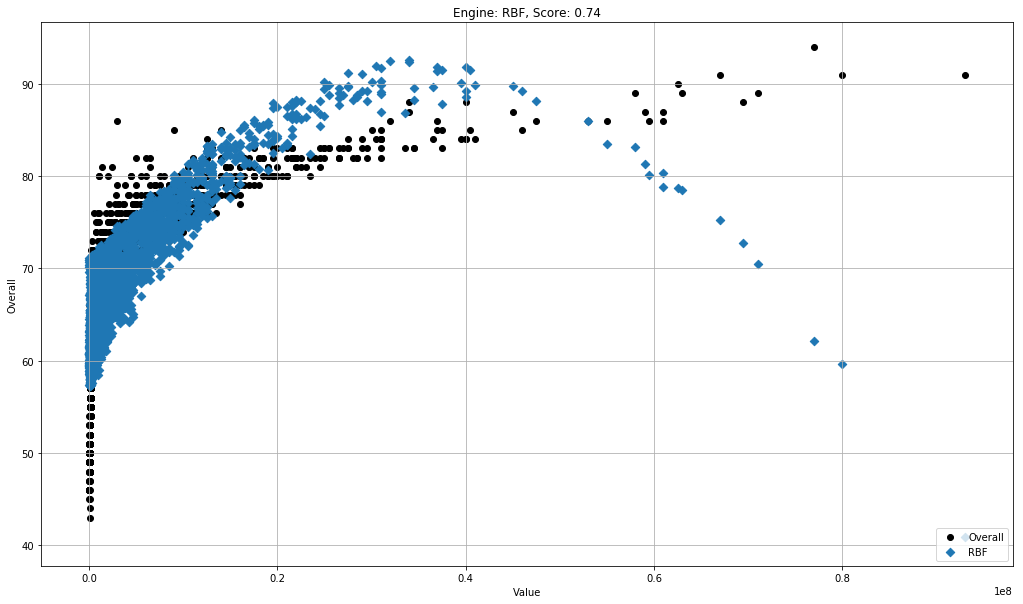

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3

returning pickle load DTR 1566693179.8917181


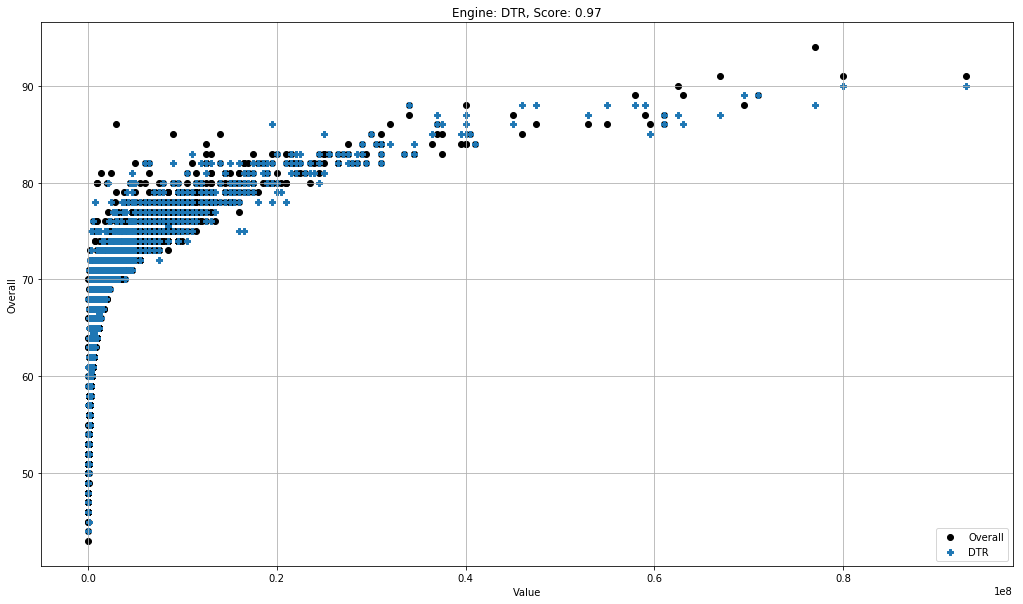

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Ridge from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages

returning pickle load Ridge 1566693180.4776506


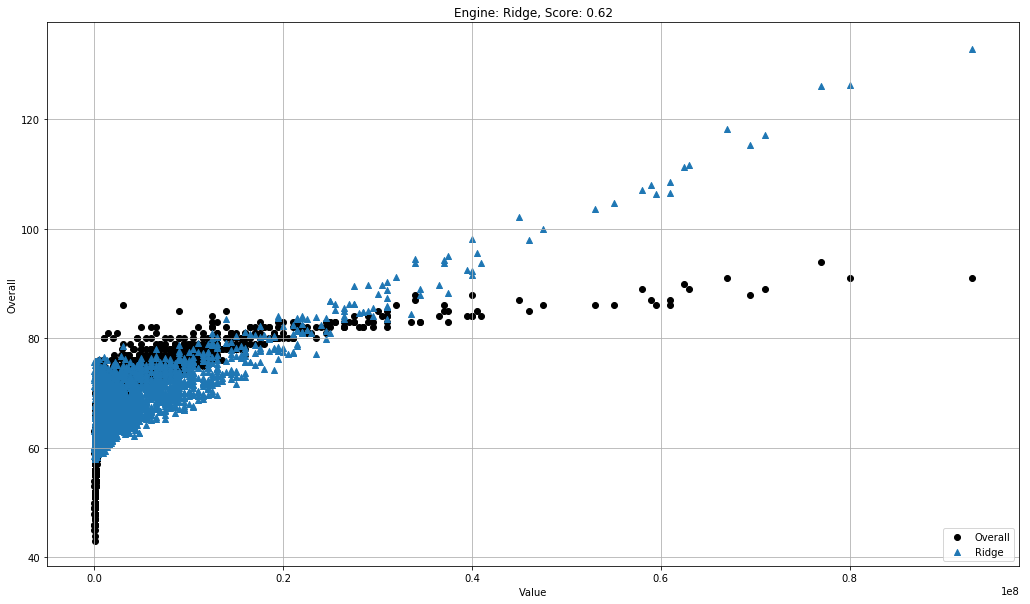

returning pickle load RC 1566693181.0907388


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 wer

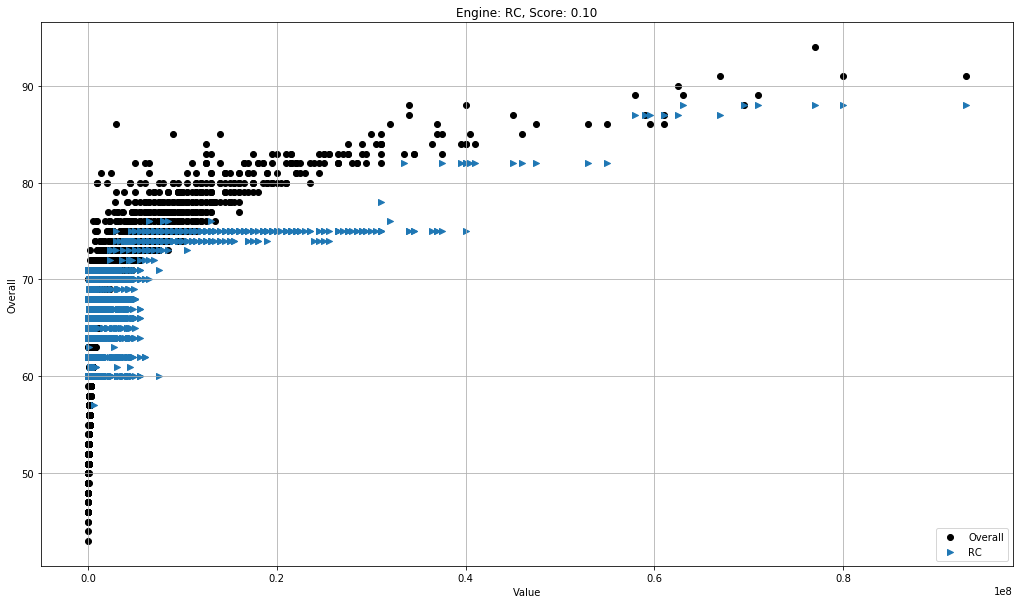

returning pickle load RCCV 1566693181.70005


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 wer

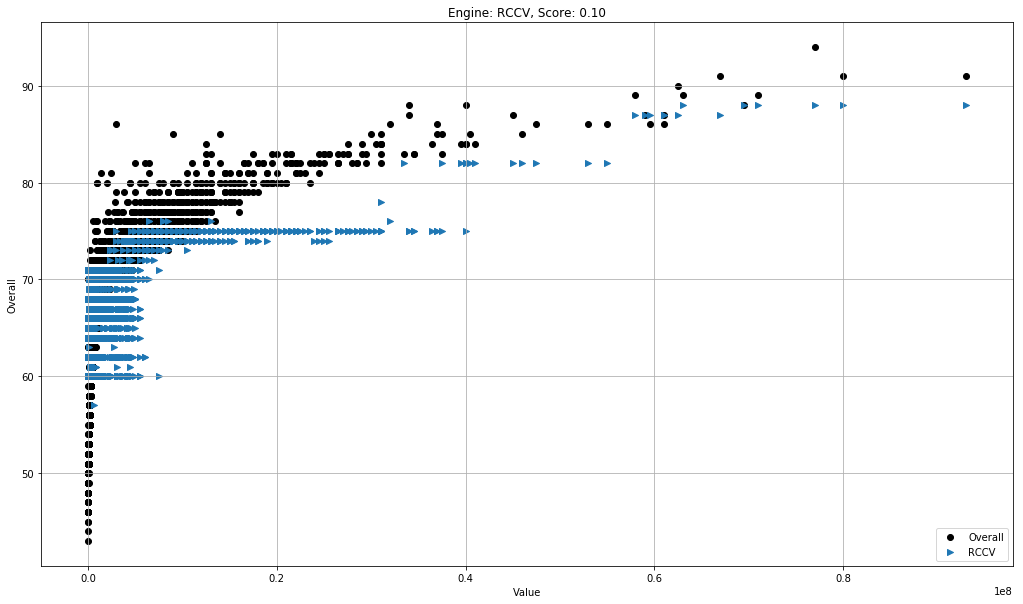

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/si

returning pickle load LR 1566693182.3835852


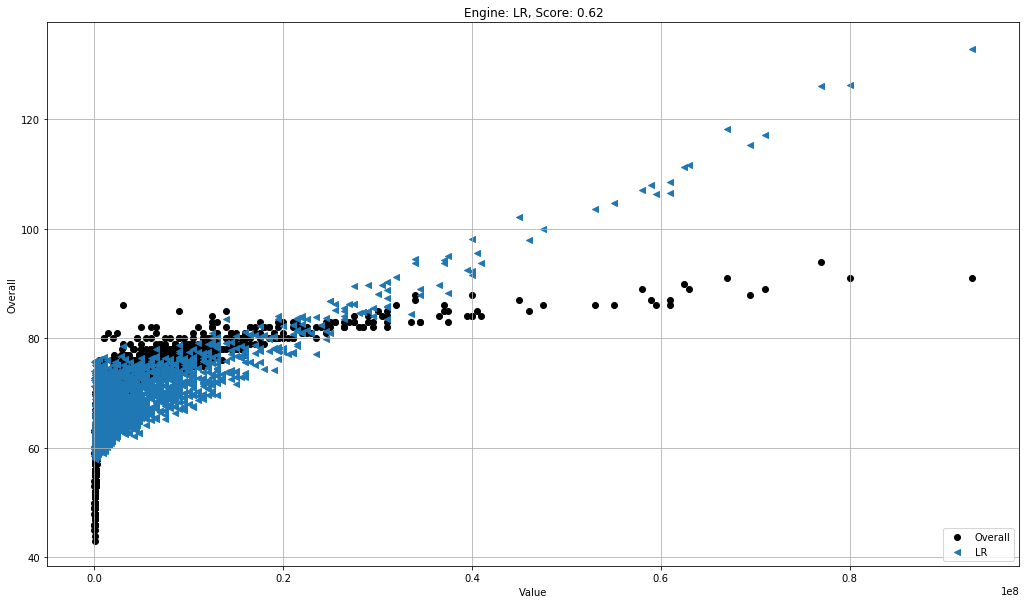

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator HuberRegressor from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site

returning pickle load HR 1566693182.8821354


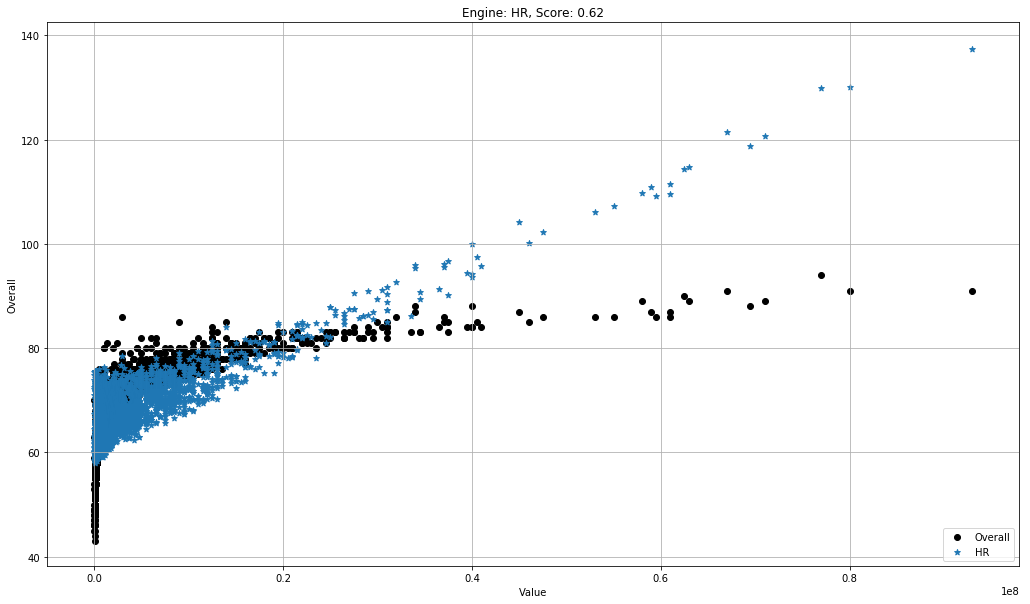

In [18]:
# Be patient this might take few minutes ;)
# Support Vector Regression - RBF (radial basis function)
# PolynomialFeatures and Ridge Regression
results  = []
ypred    = []
i        = 0
engines  = [('RBF', svm.SVR(kernel='rbf', gamma=1e-3, C=100, epsilon=0.1)),
           ('DTR', DecisionTreeRegressor()),
           ('Ridge', Ridge()),
           ('RC', RidgeClassifier()),
           ('RCCV', RidgeClassifierCV()),
           ('LR', LinearRegression(normalize=True)),
           ('HR', HuberRegressor(alpha=1.3, epsilon=4.4, tol=1e-4))]
for name, engine in engines:
#     clf = make_pipeline(StandardScaler(), FunctionTransformer(add_squared_col), engine)
    clf = pickeling(name,engine)
    clf.fit(xtrain, ytrain.values.ravel())
    ypred = clf.predict(xtest)
    
    results.append({"Engine": name, "Mean squared error": mean_squared_error(ytest, ypred),
         "Variance core": r2_score(ytest, ypred), "Accuracy score": clf.score(xtest, ytest),
          "predict": ypred})
    
    plt.figure(figsize=(18, 10))
    plt.scatter(xtest['ValueNum'], ytest['Overall'], linewidth=1, color='black')
    plt.scatter(xtest['ValueNum'], ypred, linewidth=1, label=name, marker=random.choice(marker))
    plt.xlabel("Value")
    plt.ylabel("Overall")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.title("Engine: {}, Score: {:.2f}".format(results[i]['Engine'], results[i]['Accuracy score']))
    #plt.text(2, 0.65, str(results[i]), fontsize=16)
    plt.subplots_adjust(left=0.15)
    plt.draw()
    plt.show()
    i += 1

>This may seem like this model is not very good, but, in this case we can accept a model that produces a few bad predictions, with the most of them being good, then this model is not as bad as we thought. That’s because the predictions seem to be pretty accurate for those players with a value lower than €30M. Although it can not be appreciated very well in the plot, those players represent 98.97% of the total!

In [19]:
pd.options.mode.chained_assignment = None

# minimum score we are willing to accept
min_score = 0.9

for result in results:
    if result['Accuracy score'] < min_score: continue
    test['Overall_{}'.format(result['Engine'])] = result['predict']
    test['Error_PCT_{}'.format(result['Engine'])] = np.abs((test.Overall - result['predict']) / test.Overall * 100)

> Update *test* DataFrame, add new columns from classifier and prediction 

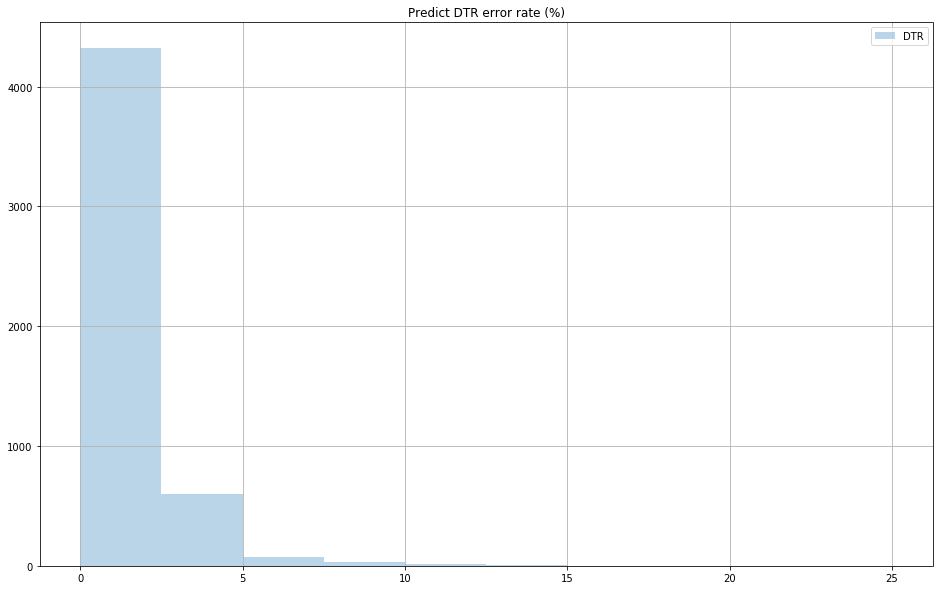

In [20]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for result in results:
    if result['Accuracy score'] < min_score: continue
    plt.figure(figsize=(16, 10))
    plt.hist(test['Error_PCT_{}'.format(result['Engine'])], **kwargs)
    plt.title("Predict {} error rate (%)".format(result['Engine']))
    plt.grid(True)
    plt.legend([result['Engine']],loc=1)
    plt.show()

>Visually, the polynomial regression looks better than the standard linear regression.

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5048 entries, 6341 to 6551
Data columns (total 18 columns):
Name             5048 non-null object
Age              5048 non-null int64
Photo            5048 non-null object
Nationality      5048 non-null object
Overall          5048 non-null int32
Potential        5048 non-null int64
Club             5048 non-null object
Value            5048 non-null object
Wage             5048 non-null object
Aggression       5048 non-null int64
Crossing         5048 non-null int64
Dribbling        5048 non-null int64
Finishing        5048 non-null int64
Penalties        5048 non-null int64
Stamina          5048 non-null int64
ValueNum         5048 non-null float64
Overall_DTR      5048 non-null float64
Error_PCT_DTR    5048 non-null float64
dtypes: float64(3), int32(1), int64(8), object(6)
memory usage: 729.6+ KB


> As you can see new columns *Overall_[engine]* and *Error_PCR_[engine]* have been added, populated with prediction and error percent rate

In [22]:
o = ['Overall_{}'.format(r['Engine']) for r in results if r['Accuracy score'] > min_score]
e = ['Error_PCT_{}'.format(r['Engine']) for r in results if r['Accuracy score'] > min_score]
t = ['Name', 'Club', 'Age', 'Value', 'Overall', ]
t.extend(o)
t.extend(e)
test[t].nlargest(40, columns=o+e).head(10)


,Name,Club,Age,Value,Overall,Overall_DTR,Error_PCT_DTR
158,E. Hazard,Chelsea,27,€93M,91,90.0,1.098901
292,L. Suárez,FC Barcelona,31,€80M,91,90.0,1.098901
192,C. Eriksen,Tottenham Hotspur,26,€69.5M,88,89.0,1.136364
203,A. Griezmann,Atlético Madrid,27,€71M,89,89.0,0.000000
77,Cristiano Ronaldo,Juventus,33,€77M,94,88.0,6.382979
155,H. Ziyech,Ajax,25,€46M,85,88.0,3.529412
71,Coutinho,FC Barcelona,26,€47.5M,86,88.0,2.325581
167,R. Lukaku,Manchester United,25,€55M,86,88.0,2.325581
784,J. Vertonghen,Tottenham Hotspur,31,€34M,87,88.0,1.149425
270,Isco,Real Madrid,26,€59M,87,88.0,1.149425


In [23]:
test.loc[
    (test.Age > 21) 
    & (test.Age < 27)
    & (test.ValueNum < 30000000)
    & ((test.Overall_DTR > test.Overall))
    , t ].nsmallest(40, columns=['Error_PCT_DTR']).head(10)

,Name,Club,Age,Value,Overall,Overall_DTR,Error_PCT_DTR
11638,S. Sprangler,Wolfsberger AC,23,€625K,64,64.5,0.781250
7994,F. Kusić,FC Erzgebirge Aue,22,€575K,64,64.5,0.781250
62,S. Haller,Eintracht Frankfurt,24,€28.5M,82,83.0,1.219512
687,Willian José,Real Sociedad,26,€26.5M,82,83.0,1.219512
3126,A. Kokorin,Zenit St. Petersburg,26,€17.5M,80,81.0,1.250000
268,A. Oxlade-Chamberlain,Liverpool,24,€18.5M,80,81.0,1.250000
438,Deulofeu,Watford,24,€19M,80,81.0,1.250000
300,Mariano,Real Madrid,24,€16M,79,80.0,1.265823
1513,D. Demme,RB Leipzig,26,€12M,79,80.0,1.265823
1203,B. Verbič,Dynamo Kyiv,24,€16M,79,80.0,1.265823


In [24]:
dfs = pd.read_html("https://www.skysports.com/premier-league-table", header=0)
df = pd.DataFrame(dfs[0], columns=["Team"])
df.rename(columns={"Team": "Club"}, inplace=True)

In [25]:
ukteams = test[test.Club.isin(df.Club)]

In [26]:
ukteams.loc[
    (ukteams.Age > 20) 
    & (ukteams.Age < 29)
    & (ukteams.ValueNum < 30000000)
    & ((ukteams.Overall_DTR > ukteams.Overall))
    , t ].nsmallest(40, columns=['Error_PCT_DTR']).head(11)

,Name,Club,Age,Value,Overall,Overall_DTR,Error_PCT_DTR
268,A. Oxlade-Chamberlain,Liverpool,24,€18.5M,80,81.0,1.250000
438,Deulofeu,Watford,24,€19M,80,81.0,1.250000
1389,M. Sakho,Crystal Palace,28,€11.5M,79,80.0,1.265823
2048,F. Lejeune,Newcastle United,27,€10M,78,79.0,1.282051
63,J. Maddison,Leicester City,21,€14.5M,78,79.0,1.282051
951,Ivan Cavaleiro,Wolverhampton Wanderers,24,€8.5M,75,76.0,1.333333
1039,A. Barreca,Newcastle United,23,€6.5M,74,75.0,1.351351
2687,R. Ghezzal,Leicester City,26,€6M,74,75.0,1.351351
1214,L. Amos,Tottenham Hotspur,21,€725K,64,65.0,1.562500
11877,S. O'Connor,Newcastle United,21,€130K,55,56.0,1.818182
